In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import sklearn.datasets

%matplotlib inline


In [2]:
iris_dataset = sklearn.datasets.load_iris()

In [3]:
iris_dataset

{'data': array([[5.1, 3.5, 1.4, 0.2],
        [4.9, 3. , 1.4, 0.2],
        [4.7, 3.2, 1.3, 0.2],
        [4.6, 3.1, 1.5, 0.2],
        [5. , 3.6, 1.4, 0.2],
        [5.4, 3.9, 1.7, 0.4],
        [4.6, 3.4, 1.4, 0.3],
        [5. , 3.4, 1.5, 0.2],
        [4.4, 2.9, 1.4, 0.2],
        [4.9, 3.1, 1.5, 0.1],
        [5.4, 3.7, 1.5, 0.2],
        [4.8, 3.4, 1.6, 0.2],
        [4.8, 3. , 1.4, 0.1],
        [4.3, 3. , 1.1, 0.1],
        [5.8, 4. , 1.2, 0.2],
        [5.7, 4.4, 1.5, 0.4],
        [5.4, 3.9, 1.3, 0.4],
        [5.1, 3.5, 1.4, 0.3],
        [5.7, 3.8, 1.7, 0.3],
        [5.1, 3.8, 1.5, 0.3],
        [5.4, 3.4, 1.7, 0.2],
        [5.1, 3.7, 1.5, 0.4],
        [4.6, 3.6, 1. , 0.2],
        [5.1, 3.3, 1.7, 0.5],
        [4.8, 3.4, 1.9, 0.2],
        [5. , 3. , 1.6, 0.2],
        [5. , 3.4, 1.6, 0.4],
        [5.2, 3.5, 1.5, 0.2],
        [5.2, 3.4, 1.4, 0.2],
        [4.7, 3.2, 1.6, 0.2],
        [4.8, 3.1, 1.6, 0.2],
        [5.4, 3.4, 1.5, 0.4],
        [5.2, 4.1, 1.5, 0.1],
  

In [16]:
X = np.array(list(map(lambda x: [x[0] + x[1], x[2] + x[3]], iris_dataset['data'])))
Y = iris_dataset['target']
X, Y

(array([[ 8.6,  1.6],
        [ 7.9,  1.6],
        [ 7.9,  1.5],
        [ 7.7,  1.7],
        [ 8.6,  1.6],
        [ 9.3,  2.1],
        [ 8. ,  1.7],
        [ 8.4,  1.7],
        [ 7.3,  1.6],
        [ 8. ,  1.6],
        [ 9.1,  1.7],
        [ 8.2,  1.8],
        [ 7.8,  1.5],
        [ 7.3,  1.2],
        [ 9.8,  1.4],
        [10.1,  1.9],
        [ 9.3,  1.7],
        [ 8.6,  1.7],
        [ 9.5,  2. ],
        [ 8.9,  1.8],
        [ 8.8,  1.9],
        [ 8.8,  1.9],
        [ 8.2,  1.2],
        [ 8.4,  2.2],
        [ 8.2,  2.1],
        [ 8. ,  1.8],
        [ 8.4,  2. ],
        [ 8.7,  1.7],
        [ 8.6,  1.6],
        [ 7.9,  1.8],
        [ 7.9,  1.8],
        [ 8.8,  1.9],
        [ 9.3,  1.6],
        [ 9.7,  1.6],
        [ 8. ,  1.7],
        [ 8.2,  1.4],
        [ 9. ,  1.5],
        [ 8.5,  1.5],
        [ 7.4,  1.5],
        [ 8.5,  1.7],
        [ 8.5,  1.6],
        [ 6.8,  1.6],
        [ 7.6,  1.5],
        [ 8.5,  2.2],
        [ 8.9,  2.3],
        [ 

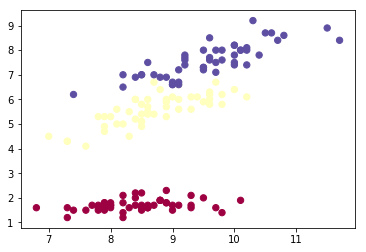

In [5]:
plt.scatter(X[:,0], X[:,1], c=Y, s=40, cmap=plt.cm.Spectral);

In [33]:
shape_X = X.shape
shape_Y = Y.shape


print ('The shape of X is: ' + str(shape_X))
print ('The shape of Y is: ' + str(shape_Y))

The shape of X is: (150, 2)
The shape of Y is: (150,)


In [45]:
Ym = np.zeros((Y.shape[0], len(set(Y))))
for (row, label) in zip(Ym, Y):
    row[label-1] = 1.0
    
Ym = Ym.T
Ym

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0.,

/Users/mk/repos/inshorts-nlp/venv/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/Users/mk/repos/inshorts-nlp/venv/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


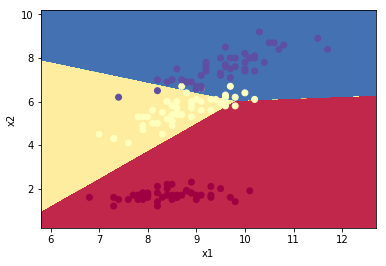

In [7]:
# Logistic regression try
import sklearn.linear_model

def plot_decision_boundary(model, X, y):
    # Set min and max values and give it some padding
    x_min, x_max = X[0, :].min() - 1, X[0, :].max() + 1
    y_min, y_max = X[1, :].min() - 1, X[1, :].max() + 1
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole grid
    Z = model(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.ylabel('x2')
    plt.xlabel('x1')
    plt.scatter(X[0, :], X[1, :], c=y, cmap=plt.cm.Spectral)

clf = sklearn.linear_model.LogisticRegressionCV();
clf.fit(X, Y);


# Plot the decision boundary for logistic regression
plot_decision_boundary(lambda x: clf.predict(x), X.T, Y.T)

In [46]:


def layers_sizes(X, Y, hidden_layers):
    """
    X -- input dataset
    Y -- labels
    hidden_layers -- vector of amounts of neurons in each hidden layer, 
                     i.e. [3,4,6] means 3 hidden layers with 3, 4 and 6 neurons accordingly
    
    Returns: array of layer sizes i.e. [34, 3, 4, 6, 2] (above example with 34 features and 2 labels dataset)
    """
    
    return [X.shape[1]] + hidden_layers + [Y.shape[0]]

layers_sizes(X, Ym, [3,4,5])
# expected [2,3,4,5,3]

[2, 3, 4, 5, 3]

In [47]:
np.random.seed(1)

def initialize_layers(layers_sizes):
    """
    layers_sizes -- array of sizes of each layes
    
    Returns: Array of weights for each layer. 
             Please note that the first layer takes the raw input - does not contain weights.
             Also, biases are excluded in this network.
    """
    result = []
    prev_size = layers_sizes[0]
    
    for size in layers_sizes[1:]:
        weights = np.random.randn(size, prev_size) * 0.01
        result += [weights]
        prev_size = size
    
    return result

initialize_layers([2,3,4])
# expected array of two matrices: 3x2 and 4x3 with random numbers



[array([[ 0.01624345, -0.00611756],
        [-0.00528172, -0.01072969],
        [ 0.00865408, -0.02301539]]),
 array([[ 0.01744812, -0.00761207,  0.00319039],
        [-0.0024937 ,  0.01462108, -0.02060141],
        [-0.00322417, -0.00384054,  0.01133769],
        [-0.01099891, -0.00172428, -0.00877858]])]

In [49]:
def sigmoid(x, derivative=False):
    sigm = 1. / (1. + np.exp(-x))
    if derivative:
        return sigm * (1. - sigm)
    return sigm

def forward_propagation(X, layers):
    """
    X -- input dataset
    layers -- array of parameters of each layer
    """
    A = X.T
    for layer in layers:
        Z = np.dot(layer, A)
        A = sigmoid(Z)
        
    return A

sizes = layers_sizes(X, Ym, [6])
layers = initialize_layers(sizes)
R = forward_propagation(X, layers)
R
# expected result: array 3x150 (3 classes, 150 examples)

array([[0.50217752, 0.50218205, 0.50218255, 0.50218286, 0.50217752,
        0.50217053, 0.50218091, 0.50217833, 0.50218593, 0.50218141,
        0.5021738 , 0.50217913, 0.50218319, 0.5021879 , 0.50217074,
        0.50216633, 0.5021725 , 0.50217703, 0.50216973, 0.5021746 ,
        0.50217475, 0.50217475, 0.50218208, 0.50217587, 0.50217765,
        0.50218042, 0.50217685, 0.50217639, 0.50217752, 0.50218107,
        0.50218107, 0.50217475, 0.50217299, 0.5021704 , 0.50218091,
        0.5021811 , 0.50217543, 0.50217866, 0.50218578, 0.50217768,
        0.50217817, 0.50218917, 0.50218449, 0.50217522, 0.50217214,
        0.50218221, 0.5021746 , 0.5021827 , 0.50217444, 0.50217947,
        0.50214501, 0.5021494 , 0.50214483, 0.5021645 , 0.50215085,
        0.50215751, 0.50214792, 0.50217266, 0.50215054, 0.50216386,
        0.50217361, 0.50215541, 0.50216339, 0.5021528 , 0.50216194,
        0.50214908, 0.50215588, 0.50216095, 0.50215718, 0.50216404,
        0.50214969, 0.50215738, 0.50215262, 0.50

In [54]:
def compute_cost(R, Y):
    """
    Arguments:
    R -- results of forward propagation (no_of_classes, no_of_examples)
    Y -- labels of exmples
    """
    
    m = Y.shape[1] # number of examples

    # Compute the cross-entropy cost
    logprobs = np.multiply(np.log(R), Y) + np.multiply((1 - Y), np.log(1 - R))
    cost = - np.sum(logprobs) / m    
    
    cost = np.squeeze(cost)     # makes sure cost is the dimension we expect. 
                                # E.g., turns [[17]] into 17 
    
    return cost

medium = compute_cost(
    np.array([[.1,.2,.3],
              [.4,.1,.4]]), 
    np.array([[0.,1.,0.],
              [1.,0.,1.]]))

big = compute_cost(
    np.array([[.1,.6,.3],
              [.8,.1,.6]]), 
    np.array([[1.,0.,1.],
              [0.,1.,0.]]))

small = compute_cost(
    np.array([[.1,.9,.1],
              [.9,.1,.9]]), 
    np.array([[0.,1.,0.],
              [1.,0.,1.]]))

small, medium, big

(0.2107210313156526, 1.336471783812265, 3.083720788832146)

In [ ]:
np.array([0.5,0.6,0.2],)